*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall23/notebooks/module02_01_nearest_neighbors.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
from matplotlib import pylab as plt

# Nearest Neighbor Classification


The nearest neighbor classifier is one of the simplest machine learning methods you can consider.
Here's the simplest version of it:


*Nearest neighbor classifier*

* Find the example in the training data that is closest to
  the example that needs to be classified.
* Return its label.


## Measuring distance

To implement this idea we need to define a concrete notion of closeness.
We'll do that using the **distance** between examples. 

First recall that the *norm* of a vector was defined as:

$$
||\mathbf{x}||^2 = \mathbf{x}^\top \mathbf{x}.
$$

Using this notation, we can define the **Euclidean distance** $d_2(\mathbf{x}, \mathbf{x}')$ between vectors $\mathbf{x}$ and $\mathbf{x}'$ as:

$$
d_2(\mathbf{x}, \mathbf{x}')^2 = ||\mathbf{x} - \mathbf{x}'||^2 = 
(\mathbf{x} - \mathbf{x}')^\top (\mathbf{x} - \mathbf{x}') = 
\sum_{i=1}^d (x_i - x_i')^2.
$$

Think of this as the length of the vector that points from $\mathbf{x}'$ to $\mathbf{x}$.

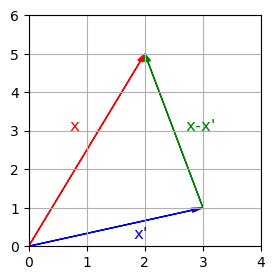

In [2]:
def plot_vector(vector, origin=[0, 0], **options):
    return plt.arrow(origin[0], origin[1], vector[0], vector[1],
              head_width=0.1, head_length=0.2, length_includes_head=True,
              **options)

x = np.array([2, 5])
x_prime = np.array([3, 1])

plt.figure(figsize=(3,3))

plot_vector(x, color="r")
plot_vector(x_prime, color="b")
plot_vector(x-x_prime, origin=x_prime, color="g")

plt.axis([0, 4, 0, 6])
plt.text(0.7, 3, "x", color="r", fontsize=12)
#plt.text(4, 3, "u", color="r", fontsize=12)
plt.text(1.8, 0.2, "x'", color="b", fontsize=12)
#plt.text(3.1, 5.6, "v", color="b", fontsize=12)
plt.text(2.7, 3, "x-x'", color="g", fontsize=12)
plt.grid()

Here are some NumPy implementations that directly reflect the different ways of expressing this definition:

In [3]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

distance(np.array([2,1]), np.array([1,0]))

1.4142135623730951

In [4]:
def distance2(x1, x2):
    return np.sqrt(np.dot(x1-x2, x1-x2))

distance2(np.array([2,1]), np.array([1,0]))

1.4142135623730951

In [5]:
def distance3(x1, x2):
    return np.sqrt(np.sum( (x1-x2)**2) )

distance3(np.array([2,1]), np.array([1,0]))

1.4142135623730951

Now we are ready to implement the nearest neighbor classifier:

In [6]:
class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        """train a nearest neighbor classifier.  Nothing much to do!"""
        self.X = X
        self.y = y
    def get_nearest(self, x):
        """returns the index of the training example closest to x"""
        distances = [distance(x, self.X[i]) 
                     for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, x) :
        return self.y[self.get_nearest(x)]

## Digit classification

Let's apply this classifier to the digit classification dataset bundled with scikit-learn.  This dataset is originally from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), and addresses handwritten image recognition.

In [7]:
from sklearn import datasets
digits = datasets.load_digits()

In [8]:
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


Each pixel in an image corresponds to a feature, so an 8 x 8 images yield a feature matrix which has 64 dimensions.  Each element in the feature matrix represents the grey-level of the pixel measured as an integer between 0 and 16:

In [9]:
X.max(),X.min()

(16.0, 0.0)

Before displaying the images, let us take a moment and look at the array of pixels for an image.

In [10]:
index = 0
print(f'The pixel values for the image with index {index} which is the digit {y[index]}')
print(np.resize(X[index,:],(8,8)))

The pixel values for the image with index 0 which is the digit 0
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


Let's visualize the first 10 examples in the dataset as images:

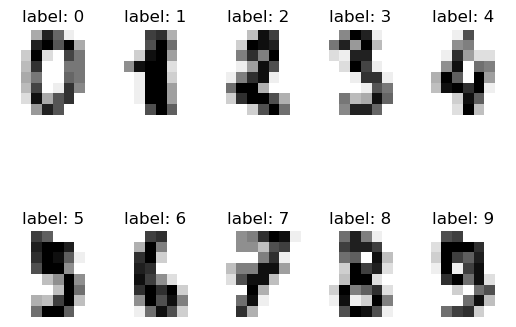

In [11]:
num_plots = 10
fig, axes = plt.subplots(2, 5)
for i in range(num_plots) :
    ax = axes[i // 5][i % 5]
    ax.set_axis_off()
    ax.imshow(np.resize(X[i], (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('label: %i' % y[i])

Next let's create histograms based on the pixel values for different classes for one select pixel:

In [12]:
def hist_pixs_by_class(X, pix_i, pix_j) :
    num_plots = 10
    Xim = X.reshape(X.shape[0],8,8)
    pix_vals = Xim[:,pix_i,pix_j]
    fig, axes = plt.subplots(5, 2)
    fig.set_size_inches(9,12)
    pix_bins = [i for i in range(17)]
 
    for i in range(num_plots) :
        ax = axes[i // 2][i % 2]
        ax.set_title(f'Digit {i}: Pixel ({pix_i},{pix_j})')
        ax.hist(pix_vals[y == i],bins=pix_bins,
                rwidth=0.75,color='orange')
        ax.set_ylim(0,200)
        ax.set_xlabel("Pixel Intensity Value")
        ax.set_ylabel("Count")
        ax.set_xticks(pix_bins)
    plt.subplots_adjust(hspace=0.75)
    

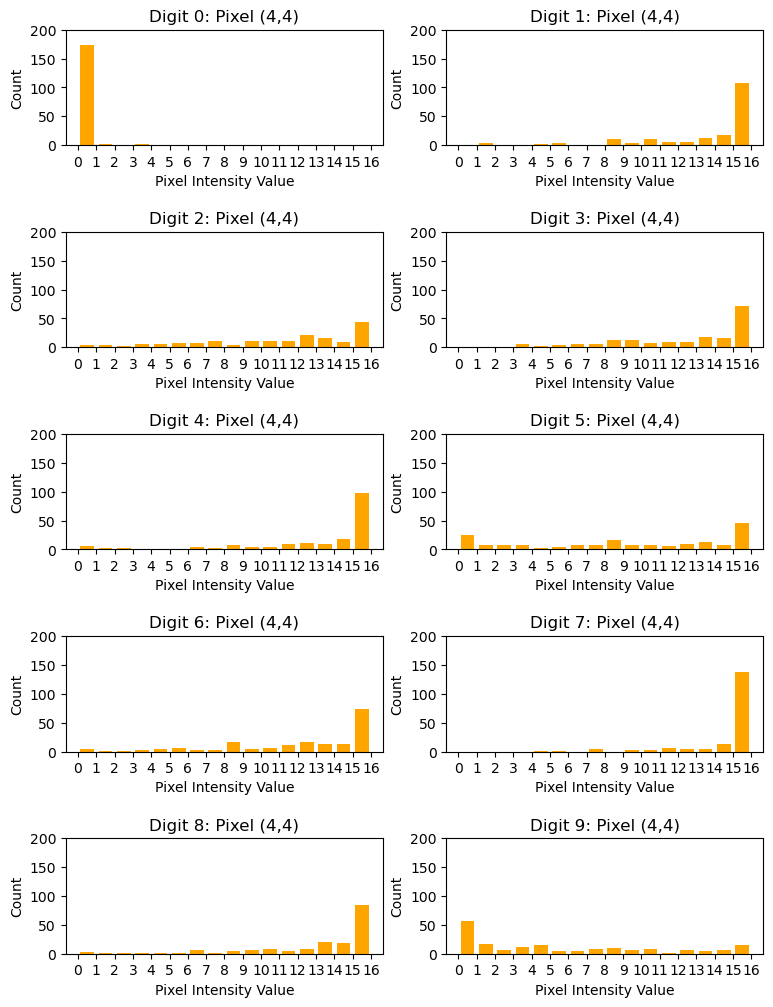

In [13]:
hist_pixs_by_class(X, 4,4)

The pixel values do seem indicative of the class label.  However, the picture is not so clear, and this is one of 64 features. Later in the course we will see ways of visualizing high dimensional data in two or three dimensions, which will help us get a better picture of what's going on overall.

Before using the nearest neighbor classifier we need to split the data into training and test sets:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.30, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape)

(1257, 64) (540, 64)


Now we are ready to classify our data:

In [15]:
nn = nearest_neighbor()
nn.fit(X_train, y_train)
y_pred = np.array([nn.predict(X_test[i]) for i in range(len(X_test))])

How accurate is our classifier?

In [16]:
acc = np.sum(y_pred == y_test)/len(y_test)
print(f'The accuracy is {acc:.3f}')

The accuracy is 0.983


Next, let's plot training examples and their closest test examples:

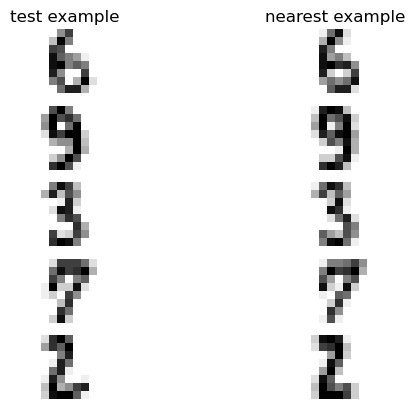

In [17]:
num_plots = 5
fig, axes = plt.subplots(5, 2);
for i in range(num_plots) :
    ax_test = axes[i][0]
    ax_nearest = axes[i][1]
    ax_test.set_axis_off()
    ax_nearest.set_axis_off()
    ax_test.imshow(np.resize(X_test[i], (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    nearest = X_train[nn.get_nearest(X_test[i])]
    ax_nearest.imshow(np.resize(nearest, (8,8)), 
              cmap=plt.cm.gray_r, interpolation='nearest')
    if (i==0):
        ax_test.set_title('test example')
        ax_nearest.set_title('nearest example')

### Reflection

We got really good accuracy using our nearest neighbor classifier.  Does this mean that we have solved the problem of digit recognition using this technique?  Do we expect this classifier to work well "in the wild"?
This is a truly important question to consider when training and evaluating machine learning methods.  Otherwise you may fool yourself and your customers into thinking that you have solved the problem when in reality, that is far from the truth.

## The decision boundary 
To obtain a better understanding of the nearest neighbor classifier let us consider the question of the shape of its decision boundary.  While the decision boundary of classifiers such as the perceptron are linear, the nearest neighbor classifier is more flexible as we will see next.

First, here's a function for plotting the decision boundary of a classifier:

In [18]:
from matplotlib.colors import ListedColormap

def plot_boundary(classifier, X, y, axes = None) :
    """
    code based on:
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    """
    classifier.fit(X, y)
    # color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    # create a two dimensional grid of points
    h = .02  # grid size
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # plot the predictions on the grid
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.5)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    

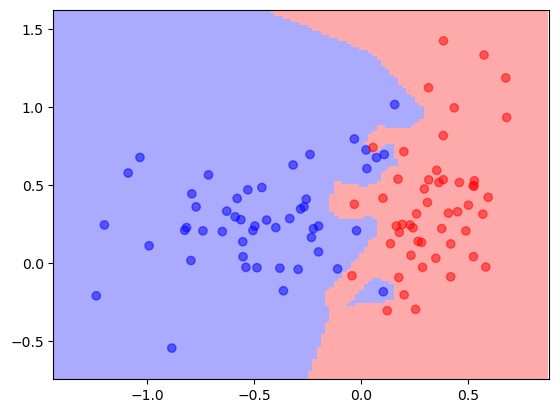

In [19]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, class_sep=0.35, random_state=1)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(1)

plot_boundary(classifier, X, y)

To further highlight the way the nearest neighbor classifier works, here's random data in two dimensions:

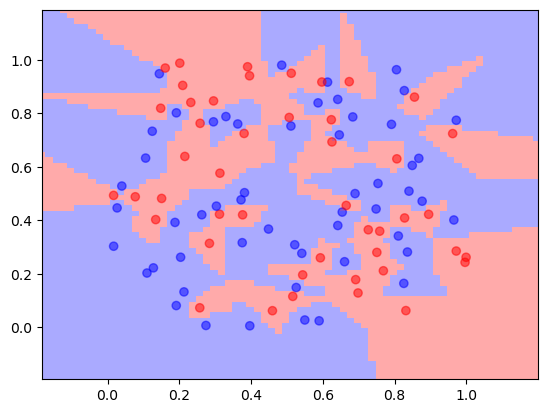

In [20]:
from numpy.random import default_rng
rng = default_rng(1)

X_random = rng.random(size=(100, 2))
y_random = rng.integers(0, 2, len(X_random))
classifier = KNeighborsClassifier(1)
plot_boundary(classifier, X_random, y_random)

### Voronoi diagrams

<img style="padding: 10px; float:left;" alt="20 points and their Voronoi cells by Balu Ertl CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/5/54/Euclidean_Voronoi_diagram.svg" width="250">

Turns out that the decision boundary of a nearest neighbor classifier is related to the concept of a **Voronoi diagram**.

Given a collection of points $\{\mathbf{x}_1,\ldots,\mathbf{x}_N\}$,
the Voronoi cell associated with point $\mathbf{x}_i$ is the set of points that are closer to $\mathbf{x}_i$ than every other point in the collection.

For nearest neighbor classification we obtain the decision boundary by merging adjacent Voronoi cells that have the same label associated with them.

### Question:

What accuracy do you expect for a nearest neighbor classifier that is tested on its training set?